Preprocessing

In [4]:
import pandas as pd

# Load datasets
train = pd.read_csv("../src/data/train.csv")
store = pd.read_csv("../src/data/store.csv")
test = pd.read_csv("../src/data/test.csv")


In [5]:
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')


Feature engineering

In [6]:
#Feature engineering
#Convert Date to datetime:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])


In [7]:
#Extract features
for df in [train, test]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)


In [8]:
#Handle missing values
train['CompetitionDistance'].fillna(99999,)
train.fillna(0,)
test['CompetitionDistance'].fillna(99999, )
test.fillna(0,)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Week,Day,IsWeekend,IsMonthStart,IsMonthEnd
0,1,1,3,2015-09-17,1.0,1,0,0,c,a,...,0.0,0.0,0,2015,9,38,17,0,0,0
1,2,3,3,2015-09-17,1.0,1,0,0,a,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,38,17,0,0,0
2,3,7,3,2015-09-17,1.0,1,0,0,a,c,...,0.0,0.0,0,2015,9,38,17,0,0,0
3,4,8,3,2015-09-17,1.0,1,0,0,a,a,...,0.0,0.0,0,2015,9,38,17,0,0,0
4,5,9,3,2015-09-17,1.0,1,0,0,a,c,...,0.0,0.0,0,2015,9,38,17,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,5,2015-08-01,1.0,0,0,0,a,a,...,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,31,1,1,1,0
41084,41085,1112,5,2015-08-01,1.0,0,0,0,c,c,...,0.0,0.0,0,2015,8,31,1,1,1,0
41085,41086,1113,5,2015-08-01,1.0,0,0,0,a,c,...,0.0,0.0,0,2015,8,31,1,1,1,0
41086,41087,1114,5,2015-08-01,1.0,0,0,0,a,c,...,0.0,0.0,0,2015,8,31,1,1,1,0


In [9]:
#Use label encoding or one-hot encoding for StoreType, Assortment, and PromoInterval
from sklearn.preprocessing import LabelEncoder

for col in ['StoreType', 'Assortment', 'PromoInterval']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))


Build Models with Sklearn Pipelines

In [10]:
#Define Features and Target:
X_train = train.drop(columns=['Sales', 'Date'])
y_train = train['Sales']
X_test = test.drop(columns=['Date'])


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [12]:
# Identify columns
categorical_columns = ['StoreType', 'Assortment', 'StateHoliday']
numeric_columns = ['CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth']

In [13]:
for col in categorical_columns:
    # Convert all values to strings
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [14]:
# Define preprocessors
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [15]:
print(X_test.isna().sum())  # Check for NaN values in X_test


Id                               0
Store                            0
DayOfWeek                        0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                    0
Year                             0
Month                            0
Week                             0
Day                              0
IsWeekend                        0
IsMonthStart                     0
IsMonthEnd                       0
dtype: int64


In [16]:
# Impute missing values in X_test before prediction
X_test = X_test.fillna(0)  # This will fill all NaN values with 0


In [17]:
print(X_test.isna().sum())  # Check for NaN values in X_test


Id                           0
Store                        0
DayOfWeek                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Week                         0
Day                          0
IsWeekend                    0
IsMonthStart                 0
IsMonthEnd                   0
dtype: int64


In [18]:
# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_columns),
        ('cat', categorical_preprocessor, categorical_columns)
    ]
)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [19]:

# Fit the pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CompetitionDistance',
                                                   'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'CompetitionOpenSinceMonth']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['StoreType', 'Assortment',
                                                   'StateHoliday'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [20]:
# Predict
y_pred = pipeline.predict(X_test)

Choosing a Loss Function

In [21]:
# Explanation: We'll use Mean Absolute Error (MAE) as the loss function.
# MAE is interpretable because it represents the average absolute difference between predicted and actual values.
# It's robust to outliers compared to Mean Squared Error (MSE) and is well-suited for sales predictions.

from sklearn.metrics import mean_absolute_error

# Example calculation of MAE on training data
y_train_pred = pipeline.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Mean Absolute Error on training data: {mae}")

Mean Absolute Error on training data: 2144.376117653673


Post Prediction Analysis

In [26]:
importances = pipeline.named_steps['model'].feature_importances_
# Retrieve feature names after preprocessing
categorical_features = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)
all_features = numeric_columns + list(categorical_features)

# Check if lengths match
assert len(all_features) == len(importances), "Feature names and importances do not match."

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 important features
print("Top 10 Important Features:")
print(feature_importance_df.head(10))


Top 10 Important Features:
                      Feature  Importance
0         CompetitionDistance    0.419150
11             StateHoliday_0    0.180876
3   CompetitionOpenSinceMonth    0.121724
1             Promo2SinceWeek    0.096759
5                 StoreType_1    0.059462
2             Promo2SinceYear    0.047018
4                 StoreType_0    0.023355
6                 StoreType_2    0.015771
7                 StoreType_3    0.014696
8                Assortment_0    0.010624


In [27]:
import numpy as np
import pandas as pd

# Generate the transformed test data using the same preprocessor
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Generate confidence intervals using the Random Forest's ensemble predictions
n_estimators = len(pipeline.named_steps['model'].estimators_)
all_predictions = np.array([tree.predict(X_test_transformed) for tree in pipeline.named_steps['model'].estimators_])
mean_prediction = np.mean(all_predictions, axis=0)
std_dev_prediction = np.std(all_predictions, axis=0)

confidence_intervals = pd.DataFrame({
    'Prediction': y_pred,
    'Lower Bound': mean_prediction - 1.96 * std_dev_prediction,
    'Upper Bound': mean_prediction + 1.96 * std_dev_prediction
})

print("Confidence intervals for the first 10 predictions:")
print(confidence_intervals.head(10))


Confidence intervals for the first 10 predictions:
    Prediction  Lower Bound   Upper Bound
0  8280.650464  4858.967435  11702.333493
1  5941.743028  5709.832722   6173.653334
2  5200.140868  2567.634228   7832.647507
3  7556.070826  4046.245039  11065.896614
4  4976.811179  3571.248512   6382.373845
5  8746.085035  5621.466000  11870.704070
6  6837.106335  6624.732805   7049.479866
7  5970.265900 -2272.274113  14212.805913
8  6068.382239  3798.485095   8338.279383
9  4696.661472  4543.591246   4849.731697


Serialize Models

In [28]:
import joblib
from datetime import datetime

# Save the model with a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f"Model saved as: {model_filename}")

# Optionally, load the model back to verify
loaded_model = joblib.load(model_filename)
print("Model loaded successfully for verification.")


Model saved as: sales_model_2025-01-08-14-21-03.pkl
Model loaded successfully for verification.


Building model with deep learning (LSTM)

In [32]:
#Isolate Time Series Data

# Ensure 'Date' column is in datetime format
train['Date'] = pd.to_datetime(train['Date'])

# Filter the data for one store as an example
store_data = train[train['Store'] == 1].sort_values('Date')

# Set 'Date' as the index
store_data.set_index('Date', inplace=True)

# Let's focus on 'Sales' for time series analysis
sales_data = store_data['Sales']


In [33]:
#Check for Stationarity, p<0.05
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller(sales_data.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -4.368104368168501
p-value: 0.0003378834614142412


In [35]:
# If the p-value > 0.05, make the series stationary by differencing
sales_data_diff = sales_data.diff().dropna()

# Check again for stationarity
result_diff = adfuller(sales_data_diff)
print(f"ADF Statistic (Differenced): {result_diff[0]}")
print(f"p-value (Differenced): {result_diff[1]}")

ADF Statistic (Differenced): -11.4941793848935
p-value (Differenced): 4.657503151741617e-21


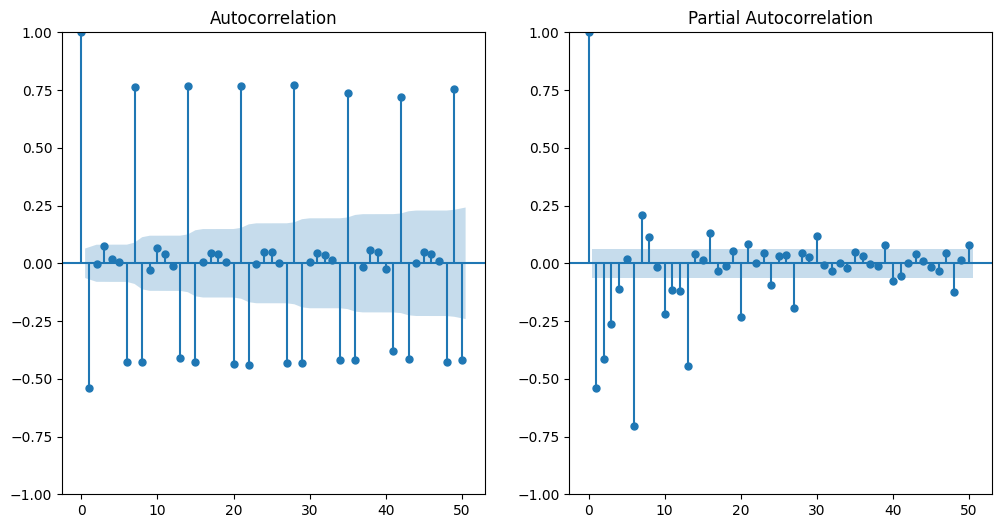

In [36]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(sales_data_diff, lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(sales_data_diff, lags=50, ax=plt.gca())
plt.show()


In [37]:
#Prepare Data for Supervised Learning
def create_supervised_data(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

# Create supervised data
lag = 30  # Look back 30 days
X, y = create_supervised_data(sales_data_diff.values, lag)

# Reshape X to be compatible with LSTM input shape
X = X.reshape(X.shape[0], X.shape[1], 1)


In [38]:
#Scale the Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1))


Building the LSTM Model

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Administrator.MMCY\Desktop\10a\Pharmaceuticals-W4\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Train the model
model.fit(X_scaled, y_scaled, epochs=20, batch_size=32)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1137
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1079
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0993
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0862
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0662
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0558
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0577
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0547
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0559
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0506
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0488
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0481
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0477
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0461
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0454
Epoc

In [45]:
# Make predictions on the test set
predictions = model.predict(X_scaled)

# Inverse the scaling to get actual sales values
predicted_sales = scaler.inverse_transform(predictions)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


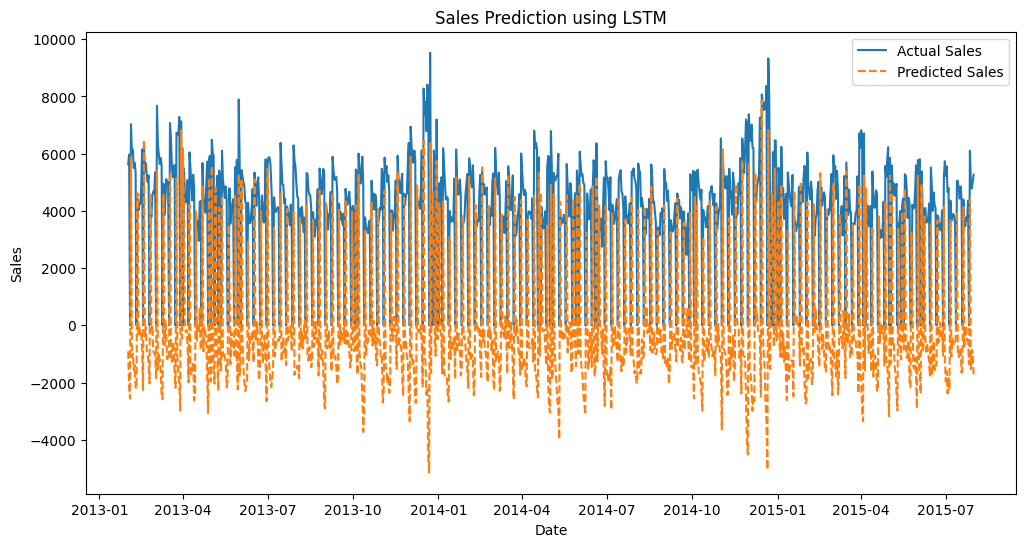

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(store_data.index[-len(predicted_sales):], sales_data[-len(predicted_sales):], label='Actual Sales')
plt.plot(store_data.index[-len(predicted_sales):], predicted_sales, label='Predicted Sales', linestyle='--')
plt.title('Sales Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [47]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(sales_data[-len(predicted_sales):], predicted_sales)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 4238.4169921875
